In [52]:
# Logistic Regression Models for MLB Pitcher Injury Prediction
# Three variants: Unmodifiable-only, Modifiable-only, and All features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import logit
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


## Step 1: Load and Prepare Data


In [53]:
# Load cleaned data
df = pd.read_csv('pitcher_data_w_injuries_cleaned.csv')
df['game_year'] = df['game_year'].astype(str)

# Split data: train (2018-2023), test (2024), forecast (2025)
train_df = df[df['game_year'].isin(['2018', '2019', '2020', '2021', '2022', '2023'])].copy()
test_df = df[df['game_year'] == '2024'].copy()
forecast_df = df[df['game_year'] == '2025'].copy()

# Define feature sets
variant1_features = ['age', 'birth_country', 'bmi', 'game_year', 'hand', 'height', 'prev_arm_inj_hist']
variant2_features = ['BB%', 'BB_max_spin', 'FB%', 'FB_max_ivb', 'FB_max_spin', 'FB_max_velo',
                     'first_year', 'game_year', 'num_bf', 'num_games', 'pitcher_role', 'vrel_sd',
                     'Δ_BB_avg_spin', 'Δ_BB_max_spin', 'Δ_FB_avg_hb', 'Δ_FB_max_ivb',
                     'Δ_FB_max_spin', 'Δ_OS_max_spin', 'Δ_num_bf']
variant3_features = variant1_features + [f for f in variant2_features if f not in variant1_features]


## Step 2: Prepare Features for Modeling


In [54]:
def prepare_data_for_modeling(df, feature_list, target='injury_next_year'):
    """Prepare data for statsmodels logistic regression."""
    available_features = [f for f in feature_list if f in df.columns]
    data = df[available_features + [target]].copy()
    
    categorical_features = []
    for col in available_features:
        if data[col].dtype == 'object' or col == 'game_year':
            categorical_features.append(col)
            data[col] = data[col].astype(str)
    
    # Handle missing values
    for col in available_features:
        if col not in categorical_features:
            if data[col].isna().sum() > 0:
                data[col] = data[col].fillna(data[col].median())
        else:
            if data[col].isna().sum() > 0:
                mode_val = data[col].mode()[0] if len(data[col].mode()) > 0 else 'Unknown'
                data[col] = data[col].fillna(mode_val)
    
    # Collapse rare categorical levels
    for col in categorical_features:
        value_counts = data[col].value_counts()
        valid_levels = value_counts[value_counts >= 5].index.tolist()
        if len(valid_levels) < len(value_counts):
            data[col] = data[col].apply(lambda x: x if x in valid_levels else 'Other')
    
    return data, available_features, categorical_features

# Prepare data for each variant
train_v1, features_v1, cat_v1 = prepare_data_for_modeling(train_df, variant1_features)
test_v1, _, _ = prepare_data_for_modeling(test_df, variant1_features)
forecast_v1, _, _ = prepare_data_for_modeling(forecast_df, variant1_features)

train_v2, features_v2, cat_v2 = prepare_data_for_modeling(train_df, variant2_features)
test_v2, _, _ = prepare_data_for_modeling(test_df, variant2_features)
forecast_v2, _, _ = prepare_data_for_modeling(forecast_df, variant2_features)

train_v3, features_v3, cat_v3 = prepare_data_for_modeling(train_df, variant3_features)
test_v3, _, _ = prepare_data_for_modeling(test_df, variant3_features)
forecast_v3, _, _ = prepare_data_for_modeling(forecast_df, variant3_features)


## Step 3: Build Logistic Regression Models


In [61]:
def build_logistic_model(train_data, features, categorical_features, target='injury_next_year'):
    """
    Build logistic regression model using statsmodels.
    Creates formula with C() for categorical variables (game_year with 2018 as baseline).
    Uses Q() to quote feature names with special characters.
    Note: Q() is a built-in function in patsy's formula language, no import needed.
    """
    # Helper function to quote feature names with special characters
    def quote_feature(feat_name):
        # Check if feature name contains special characters that need quoting
        special_chars = ['%', 'Δ', ' ', '-', '+', '*', '/', '(', ')', '[', ']', '{', '}']
        if any(char in feat_name for char in special_chars):
            return f"Q('{feat_name}')"
        return feat_name
    
    # Build formula string
    formula_parts = []
    
    for feat in features:
        if feat in categorical_features:
            quoted_feat = quote_feature(feat)
            if feat == 'game_year':
                # Set 2018 as baseline using Treatment coding
                formula_parts.append(f"C({quoted_feat}, Treatment(reference='2018'))")
            else:
                formula_parts.append(f"C({quoted_feat})")
        else:
            formula_parts.append(quote_feature(feat))
    
    formula = f"{target} ~ " + " + ".join(formula_parts)
    
    # Try to fit model with error handling
    try:
        model = logit(formula, data=train_data).fit(disp=0, maxiter=1000)
        return model, formula
    except (np.linalg.LinAlgError, ValueError) as e:
        # Check for problematic categorical variables
        problematic_features = []
        for cat_feat in categorical_features:
            if cat_feat in features:
                value_counts = train_data[cat_feat].value_counts()
                if len(value_counts) <= 1:
                    problematic_features.append(cat_feat)
        
        # Remove problematic features
        features = [f for f in features if f not in problematic_features]
        categorical_features = [c for c in categorical_features if c not in problematic_features]
        
        # Rebuild formula
        formula_parts = []
        for feat in features:
            quoted_feat = quote_feature(feat)
            if feat in categorical_features:
                if feat == 'game_year':
                    formula_parts.append(f"C({quoted_feat}, Treatment(reference='2018'))")
                else:
                    formula_parts.append(f"C({quoted_feat})")
            else:
                formula_parts.append(quoted_feat)
        
        formula = f"{target} ~ " + " + ".join(formula_parts)
        
        # Try again
        try:
            model = logit(formula, data=train_data).fit(disp=0, maxiter=1000)
            return model, formula
        except (np.linalg.LinAlgError, ValueError) as e2:
            # Use sklearn as fallback with regularization
            try:
                from sklearn.linear_model import LogisticRegression
                from sklearn.preprocessing import StandardScaler
                
                # Prepare design matrix manually
                X_list = []
                feature_names = []
                
                # Add numerical features
                for feat in features:
                    if feat not in categorical_features:
                        X_list.append(train_data[feat].values.reshape(-1, 1))
                        feature_names.append(feat)
                
                # Add categorical features (one-hot encoded)
                for feat in categorical_features:
                    if feat in features:
                        dummies = pd.get_dummies(train_data[feat], prefix=feat, drop_first=True)
                        if feat == 'game_year':
                            # Ensure 2018 is the dropped reference
                            if 'game_year_2018' in dummies.columns:
                                dummies = dummies.drop('game_year_2018', axis=1)
                        X_list.append(dummies.values)
                        feature_names.extend(dummies.columns.tolist())
                
                # Combine all features
                X = np.hstack(X_list) if len(X_list) > 1 else X_list[0]
                y = train_data[target].values
                
                # Standardize features
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                
                # Fit with regularization
                lr = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='lbfgs', random_state=42)
                lr.fit(X_scaled, y)
                
                # Create a wrapper class to mimic statsmodels interface
                class SklearnLogitWrapper:
                    def __init__(self, sklearn_model, scaler, feature_names, formula, 
                                 original_features, original_categorical_features, y_true, X_scaled):
                        self.sklearn_model = sklearn_model
                        self.scaler = scaler
                        self.feature_names = feature_names
                        self.formula = formula
                        self.original_features = original_features
                        self.original_categorical_features = original_categorical_features
                        self.nobs = len(y_true)
                        
                        # Create params Series with intercept and coefficients
                        coef_dict = {'Intercept': sklearn_model.intercept_[0]}
                        coef_dict.update(dict(zip(feature_names, sklearn_model.coef_[0])))
                        self.params = pd.Series(coef_dict)
                        self.mle_retvals = {'converged': True}
                        
                        # Calculate AIC, BIC, and log-likelihood
                        y_pred_proba = sklearn_model.predict_proba(X_scaled)[:, 1]
                        # Avoid log(0) or log(1)
                        y_pred_proba = np.clip(y_pred_proba, 1e-10, 1 - 1e-10)
                        self.llf = np.sum(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))
                        k = len(feature_names) + 1  # +1 for intercept
                        self.aic = -2 * self.llf + 2 * k
                        self.bic = -2 * self.llf + k * np.log(self.nobs)
                        
                        # Calculate pseudo R-squared (McFadden's)
                        # Null model log-likelihood
                        null_proba = y_true.mean()
                        null_llf = np.sum(y_true * np.log(null_proba) + (1 - y_true) * np.log(1 - null_proba))
                        self.prsquared = 1 - (self.llf / null_llf) if null_llf != 0 else 0.0
                        
                    def predict(self, data):
                        # Prepare data the same way as training
                        X_list = []
                        for feat in self.original_features:
                            if feat not in self.original_categorical_features:
                                X_list.append(data[feat].values.reshape(-1, 1))
                        for feat in self.original_categorical_features:
                            if feat in self.original_features:
                                dummies = pd.get_dummies(data[feat], prefix=feat, drop_first=True)
                                if feat == 'game_year' and 'game_year_2018' in dummies.columns:
                                    dummies = dummies.drop('game_year_2018', axis=1)
                                # Align columns with training feature names
                                expected_cols = [c for c in self.feature_names if c.startswith(feat)]
                                for col in expected_cols:
                                    if col not in dummies.columns:
                                        dummies[col] = 0
                                dummies = dummies.reindex(columns=expected_cols, fill_value=0)
                                X_list.append(dummies.values)
                        X_new = np.hstack(X_list) if len(X_list) > 1 else X_list[0]
                        X_new_scaled = self.scaler.transform(X_new)
                        return self.sklearn_model.predict_proba(X_new_scaled)[:, 1]
                    
                    def summary(self):
                        """Create a summary object similar to statsmodels."""
                        class Summary:
                            def __init__(self, wrapper):
                                self.wrapper = wrapper
                            
                            def __str__(self):
                                """Display summary as formatted string."""
                                lines = []
                                lines.append("=" * 80)
                                lines.append("Logit Regression Results (sklearn wrapper)")
                                lines.append("=" * 80)
                                lines.append(f"Dep. Variable:       injury_next_year   No. Observations:     {self.wrapper.nobs}")
                                lines.append(f"Model:                          Logit   Pseudo R-squ.:      {self.wrapper.prsquared:.6f}")
                                lines.append(f"Method:                           MLE   Log-Likelihood:     {self.wrapper.llf:.2f}")
                                lines.append(f"Converged:                       True   AIC:                 {self.wrapper.aic:.2f}")
                                lines.append(f"                                                              BIC:                 {self.wrapper.bic:.2f}")
                                lines.append("=" * 80)
                                lines.append(f"{'coef':<40} {'value':>15}")
                                lines.append("-" * 80)
                                
                                # Display coefficients (top 20 to avoid overwhelming output)
                                coef_items = list(self.wrapper.params.items())[:20]
                                for name, value in coef_items:
                                    lines.append(f"{name[:39]:<40} {value:>15.4f}")
                                
                                if len(self.wrapper.params) > 20:
                                    lines.append(f"... and {len(self.wrapper.params) - 20} more coefficients")
                                
                                lines.append("=" * 80)
                                return "\n".join(lines)
                            
                            @property
                            def tables(self):
                                # Create a simple table with coefficients
                                data = []
                                for name, value in self.wrapper.params.items():
                                    data.append([name, f"{value:.4f}"])
                                
                                class Table:
                                    def __init__(self, data):
                                        self.data = data
                                    
                                    def __str__(self):
                                        return "\n".join([f"{row[0]:<30} {row[1]:>15}" for row in self.data])
                                
                                return [Table(data)]
                        
                        return Summary(self)
                
                model = SklearnLogitWrapper(lr, scaler, feature_names, formula, features, categorical_features, y, X_scaled)
                return model, formula
                
            except Exception as e3:
                raise Exception(f"Could not fit model even with sklearn fallback: {e3}")

# Build models for all three variants
model_v1, formula_v1 = build_logistic_model(train_v1, features_v1, cat_v1)
model_v2, formula_v2 = build_logistic_model(train_v2, features_v2, cat_v2)
model_v3, formula_v3 = build_logistic_model(train_v3, features_v3, cat_v3)

# Display model summaries using statsmodels
for variant, name in [(1, 'Variant 1'), (2, 'Variant 2'), (3, 'Variant 3')]:
    model = globals()[f'model_v{variant}']
    print(f"\n{name} Summary:")
    print("=" * 80)
    summary = model.summary()
    if hasattr(summary, '__str__'):
        print(str(summary))
    else:
        print(summary)



Variant 1 Summary:
Logit Regression Results (sklearn wrapper)
Dep. Variable:       injury_next_year   No. Observations:     4695
Model:                          Logit   Pseudo R-squ.:      0.030639
Method:                           MLE   Log-Likelihood:     -2285.45
Converged:                       True   AIC:                 4630.89
                                                              BIC:                 4824.52
coef                                               value
--------------------------------------------------------------------------------
Intercept                                        -1.4620
age                                              -0.1751
bmi                                              -0.0717
height                                            0.0566
prev_arm_inj_hist                                 0.1714
birth_country_Canada                             -0.0835
birth_country_China                              -0.0060
birth_country_Colombia             

In [56]:
# Generate predictions for all datasets
def get_predictions(model, data, target='injury_next_year'):
    """Get predicted probabilities from model. Handles both statsmodels and sklearn wrapper."""
    try:
        # Check if it's a statsmodels model (has 'fittedvalues' attribute) or sklearn wrapper
        if hasattr(model, 'fittedvalues'):
            # Statsmodels model - for formula-based models, predict() should work with DataFrame
            # Ensure data has the target column (statsmodels formula needs it for evaluation)
            data_for_pred = data.copy()
            if target not in data_for_pred.columns:
                # Add dummy target column if missing
                data_for_pred[target] = 0
            
            # For statsmodels formula models, predict() should work directly
            # It uses the stored formula to construct the design matrix from the DataFrame
            try:
                # Direct predict call - statsmodels will use the stored formula
                predictions = model.predict(data_for_pred)
            except Exception as e1:
                # If that fails, the issue might be with categorical levels or missing columns
                error_msg = str(e1)
                # Check if it's a categorical level mismatch (common with game_year)
                if "does not match any of the expected levels" in error_msg or "PatsyError" in str(type(e1).__name__):
                    # Fix unseen categorical levels
                    data_for_pred_fixed = data_for_pred.copy()
                    if 'game_year' in data_for_pred_fixed.columns:
                        training_years = ['2018', '2019', '2020', '2021', '2022', '2023']
                        for year in data_for_pred_fixed['game_year'].unique():
                            if str(year) not in training_years:
                                data_for_pred_fixed['game_year'] = data_for_pred_fixed['game_year'].replace(str(year), '2023')
                    try:
                        predictions = model.predict(data_for_pred_fixed)
                    except Exception as e2:
                        raise
                else:
                    raise
        elif hasattr(model, 'predict'):
            # Sklearn wrapper or sklearn model
            predictions = model.predict(data)
        else:
            raise AttributeError("Model does not have predict method")
        
        # Convert to numpy array if needed
        if hasattr(predictions, 'values'):
            predictions = predictions.values
        if hasattr(predictions, 'flatten'):
            predictions = predictions.flatten()
        predictions = np.array(predictions)
        
        # Ensure predictions are probabilities (0-1 range) and handle any infinities
        predictions = np.clip(predictions, 0, 1)
        predictions = np.nan_to_num(predictions, nan=np.nan)
        return predictions
    except Exception as e:
        return np.full(len(data), np.nan)

# Generate predictions
train_pred_v1 = get_predictions(model_v1, train_v1)
train_pred_v2 = get_predictions(model_v2, train_v2)
train_pred_v3 = get_predictions(model_v3, train_v3)

test_pred_v1 = get_predictions(model_v1, test_v1)
test_pred_v2 = get_predictions(model_v2, test_v2)
test_pred_v3 = get_predictions(model_v3, test_v3)

forecast_pred_v1 = get_predictions(model_v1, forecast_v1)
forecast_pred_v2 = get_predictions(model_v2, forecast_v2)
forecast_pred_v3 = get_predictions(model_v3, forecast_v3)

  Variant  Train Log Loss  Test Log Loss  Train Brier Score  Test Brier Score  Train ROC-AUC  Test ROC-AUC
Variant 1        0.486783       0.527800           0.156144          0.172382       0.618137      0.566673
Variant 2        0.473491       0.519701           0.151773          0.171478       0.667274      0.621750
Variant 3        0.463079       0.512470           0.148652          0.168496       0.695338      0.639639


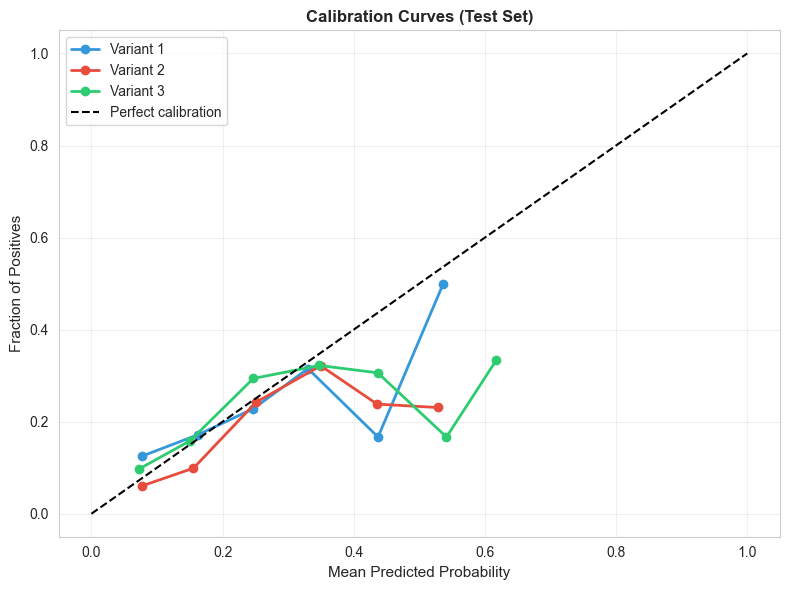

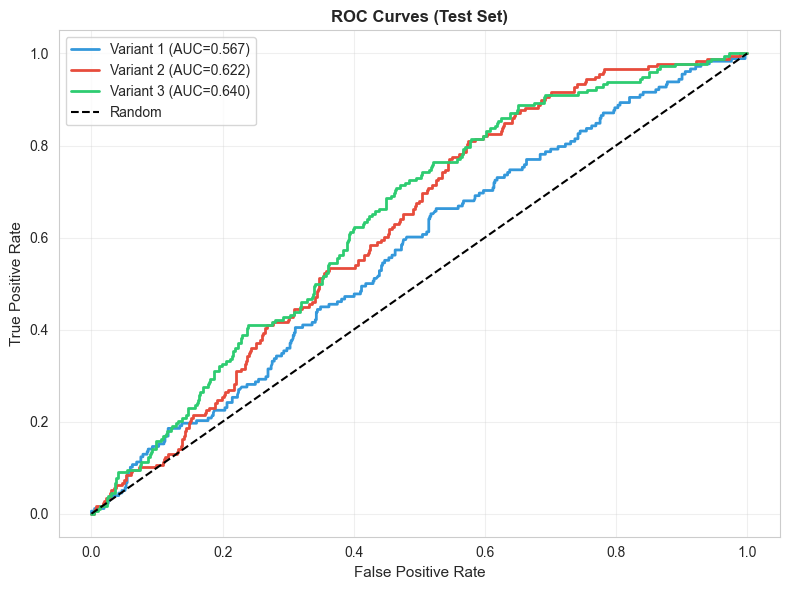

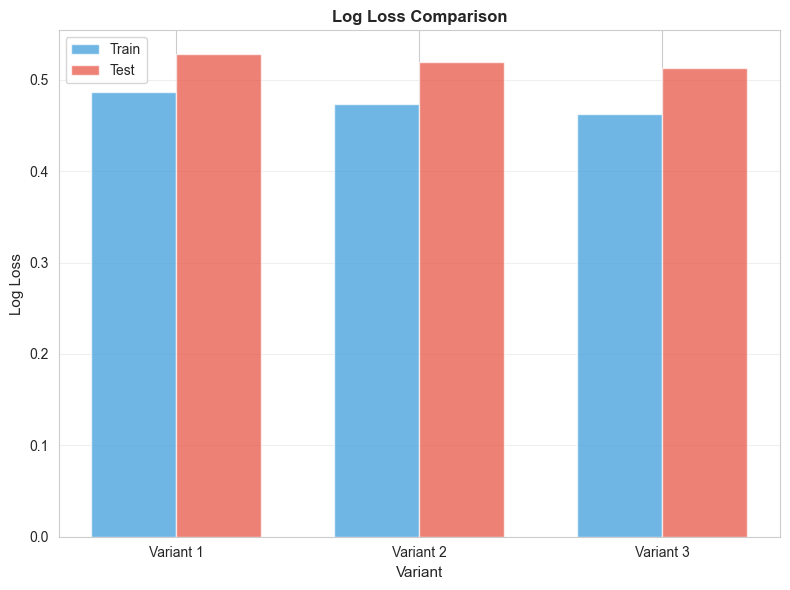

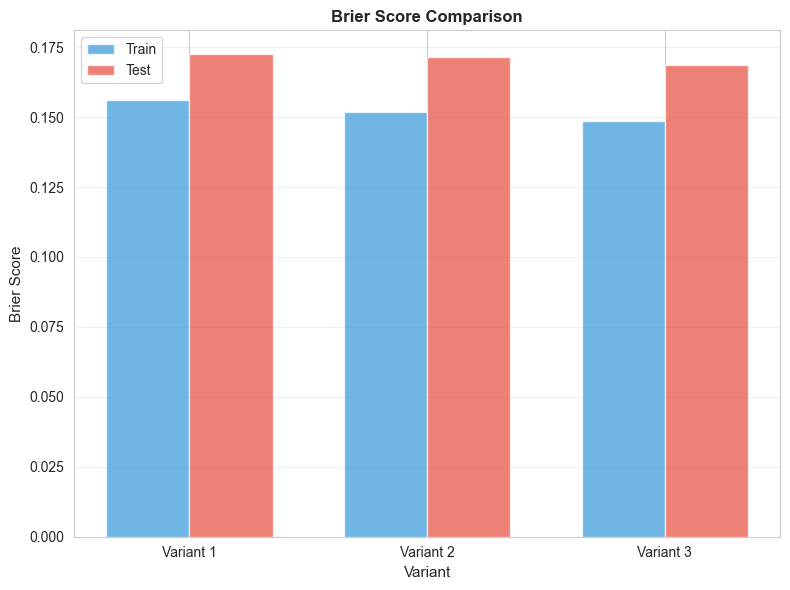

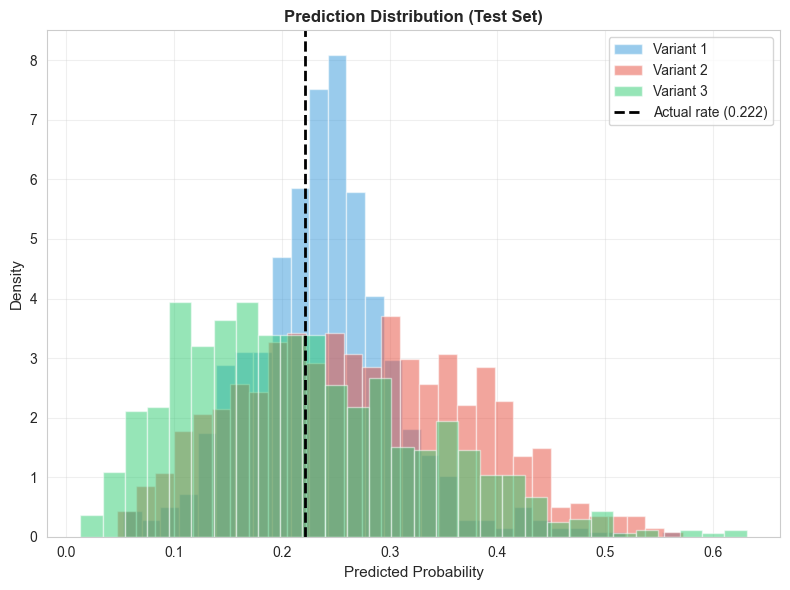

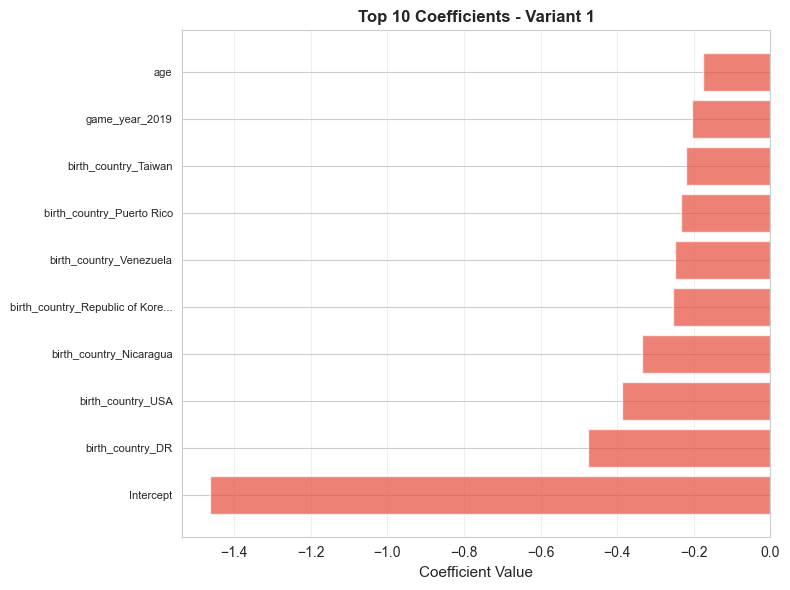

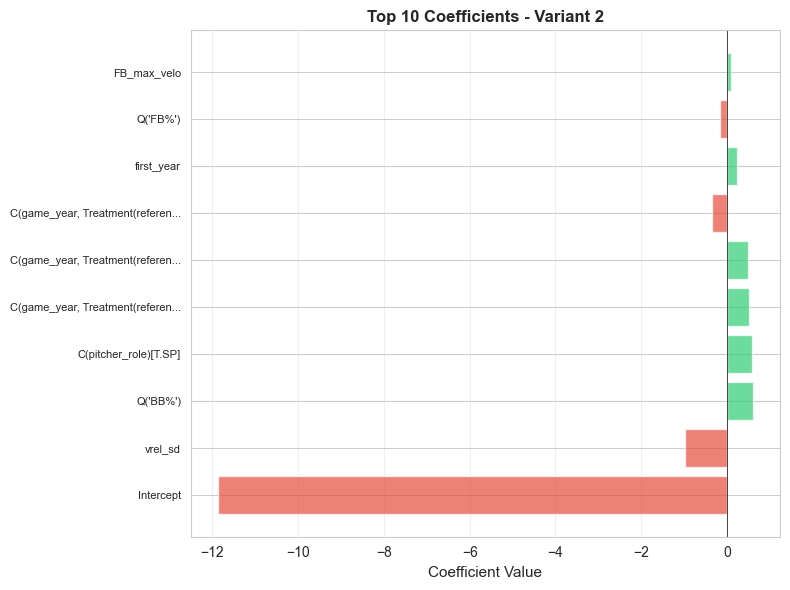

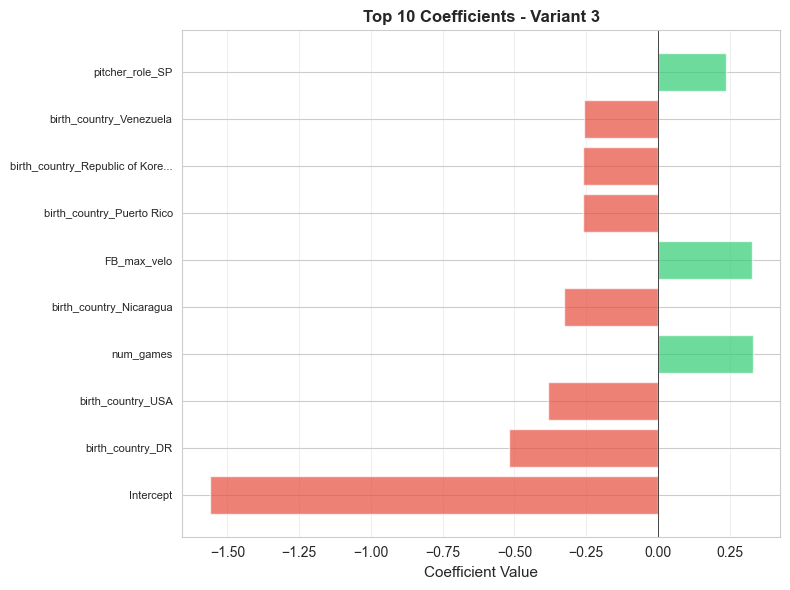

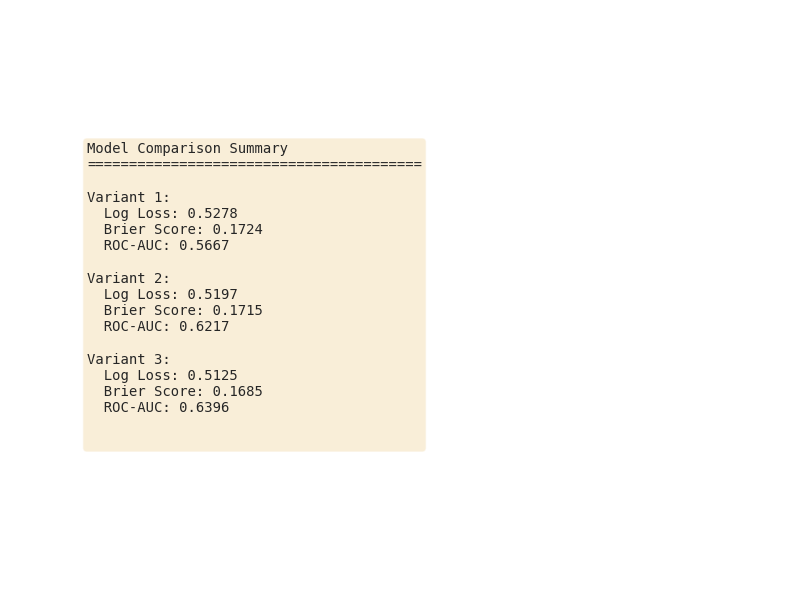

In [57]:
# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    """Calculate calibration-focused metrics."""
    # Remove NaN predictions
    valid_mask = ~np.isnan(y_pred)
    if valid_mask.sum() == 0:
        return None
    
    y_true_clean = y_true[valid_mask]
    y_pred_clean = y_pred[valid_mask]
    
    if len(y_true_clean) == 0 or y_pred_clean.std() == 0:
        return None
    
    metrics = {
        'log_loss': log_loss(y_true_clean, y_pred_clean),
        'brier_score': brier_score_loss(y_true_clean, y_pred_clean),
        'roc_auc': roc_auc_score(y_true_clean, y_pred_clean) if len(np.unique(y_true_clean)) > 1 else np.nan,
        'mean_pred': y_pred_clean.mean(),
        'actual_rate': y_true_clean.mean()
    }
    return metrics

# Calculate metrics for all variants
results = {}
for variant, name in [(1, 'Variant 1 (Unmodifiable)'), (2, 'Variant 2 (Modifiable)'), (3, 'Variant 3 (All)')]:
    results[name] = {}
    
    # Get corresponding datasets
    train_data = globals()[f'train_v{variant}']
    test_data = globals()[f'test_v{variant}']
    
    train_pred = globals()[f'train_pred_v{variant}']
    train_metrics = calculate_metrics(train_data['injury_next_year'].values, train_pred)
    results[name]['train'] = train_metrics
    
    test_pred = globals()[f'test_pred_v{variant}']
    test_metrics = calculate_metrics(test_data['injury_next_year'].values, test_pred)
    results[name]['test'] = test_metrics

# Display results as DataFrame
metrics_df = pd.DataFrame({
    'Variant': ['Variant 1', 'Variant 2', 'Variant 3'],
    'Train Log Loss': [results[f'Variant {i} ({"Unmodifiable" if i==1 else "Modifiable" if i==2 else "All"})']['train']['log_loss'] for i in [1,2,3]],
    'Test Log Loss': [results[f'Variant {i} ({"Unmodifiable" if i==1 else "Modifiable" if i==2 else "All"})']['test']['log_loss'] for i in [1,2,3]],
    'Train Brier Score': [results[f'Variant {i} ({"Unmodifiable" if i==1 else "Modifiable" if i==2 else "All"})']['train']['brier_score'] for i in [1,2,3]],
    'Test Brier Score': [results[f'Variant {i} ({"Unmodifiable" if i==1 else "Modifiable" if i==2 else "All"})']['test']['brier_score'] for i in [1,2,3]],
    'Train ROC-AUC': [results[f'Variant {i} ({"Unmodifiable" if i==1 else "Modifiable" if i==2 else "All"})']['train']['roc_auc'] for i in [1,2,3]],
    'Test ROC-AUC': [results[f'Variant {i} ({"Unmodifiable" if i==1 else "Modifiable" if i==2 else "All"})']['test']['roc_auc'] for i in [1,2,3]]
})
print(metrics_df.to_string(index=False))

# Create separate visualizations for each plot

# 1. Calibration curves for test set
fig1, ax1 = plt.subplots(figsize=(8, 6))
for variant, name, color in [(1, 'Variant 1', '#3498db'), (2, 'Variant 2', '#e74c3c'), (3, 'Variant 3', '#2ecc71')]:
    test_pred = globals()[f'test_pred_v{variant}']
    test_data = globals()[f'test_v{variant}']
    test_true = test_data['injury_next_year'].values
    valid_mask = ~np.isnan(test_pred)
    if valid_mask.sum() > 0:
        y_true_clean = test_true[valid_mask]
        y_pred_clean = test_pred[valid_mask]
        if len(np.unique(y_true_clean)) > 1:
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true_clean, y_pred_clean, n_bins=10, strategy='uniform'
            )
            ax1.plot(mean_predicted_value, fraction_of_positives, 'o-', label=name, color=color, linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=1.5)
ax1.set_xlabel('Mean Predicted Probability', fontsize=11)
ax1.set_ylabel('Fraction of Positives', fontsize=11)
ax1.set_title('Calibration Curves (Test Set)', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. ROC curves for test set
fig2, ax2 = plt.subplots(figsize=(8, 6))
for variant, name, color in [(1, 'Variant 1', '#3498db'), (2, 'Variant 2', '#e74c3c'), (3, 'Variant 3', '#2ecc71')]:
    test_pred = globals()[f'test_pred_v{variant}']
    test_data = globals()[f'test_v{variant}']
    test_true = test_data['injury_next_year'].values
    valid_mask = ~np.isnan(test_pred)
    if valid_mask.sum() > 0:
        y_true_clean = test_true[valid_mask]
        y_pred_clean = test_pred[valid_mask]
        if len(np.unique(y_true_clean)) > 1:
            fpr, tpr, _ = roc_curve(y_true_clean, y_pred_clean)
            auc = roc_auc_score(y_true_clean, y_pred_clean)
            ax2.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color, linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curves (Test Set)', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Log Loss comparison
fig3, ax3 = plt.subplots(figsize=(8, 6))
variants = ['Variant 1', 'Variant 2', 'Variant 3']
train_logloss = [results[f'{v} ({"Unmodifiable" if "1" in v else "Modifiable" if "2" in v else "All"})']['train']['log_loss'] 
                 if results[f'{v} ({"Unmodifiable" if "1" in v else "Modifiable" if "2" in v else "All"})']['train'] else np.nan
                 for v in variants]
test_logloss = [results[f'{v} ({"Unmodifiable" if "1" in v else "Modifiable" if "2" in v else "All"})']['test']['log_loss']
                if results[f'{v} ({"Unmodifiable" if "1" in v else "Modifiable" if "2" in v else "All"})']['test'] else np.nan
                for v in variants]
x = np.arange(len(variants))
width = 0.35
ax3.bar(x - width/2, train_logloss, width, label='Train', color='#3498db', alpha=0.7)
ax3.bar(x + width/2, test_logloss, width, label='Test', color='#e74c3c', alpha=0.7)
ax3.set_xlabel('Variant', fontsize=11)
ax3.set_ylabel('Log Loss', fontsize=11)
ax3.set_title('Log Loss Comparison', fontweight='bold', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(variants)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 4. Brier Score comparison
fig4, ax4 = plt.subplots(figsize=(8, 6))
train_brier = [results[f'{v} ({"Unmodifiable" if "1" in v else "Modifiable" if "2" in v else "All"})']['train']['brier_score']
               if results[f'{v} ({"Unmodifiable" if "1" in v else "Modifiable" if "2" in v else "All"})']['train'] else np.nan
               for v in variants]
test_brier = [results[f'{v} ({"Unmodifiable" if "1" in v else "Modifiable" if "2" in v else "All"})']['test']['brier_score']
              if results[f'{v} ({"Unmodifiable" if "1" in v else "Modifiable" if "2" in v else "All"})']['test'] else np.nan
              for v in variants]
ax4.bar(x - width/2, train_brier, width, label='Train', color='#3498db', alpha=0.7)
ax4.bar(x + width/2, test_brier, width, label='Test', color='#e74c3c', alpha=0.7)
ax4.set_xlabel('Variant', fontsize=11)
ax4.set_ylabel('Brier Score', fontsize=11)
ax4.set_title('Brier Score Comparison', fontweight='bold', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(variants)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 5. Prediction distribution comparison
fig5, ax5 = plt.subplots(figsize=(8, 6))
for variant, name, color in [(1, 'Variant 1', '#3498db'), (2, 'Variant 2', '#e74c3c'), (3, 'Variant 3', '#2ecc71')]:
    test_pred = globals()[f'test_pred_v{variant}']
    test_data = globals()[f'test_v{variant}']
    valid_pred = test_pred[~np.isnan(test_pred)]
    if len(valid_pred) > 0:
        ax5.hist(valid_pred, bins=30, alpha=0.5, label=name, color=color, density=True)
actual_rate = test_v1['injury_next_year'].mean()  # Use any variant for actual rate (should be same)
ax5.axvline(actual_rate, color='k', linestyle='--', 
            label=f'Actual rate ({actual_rate:.3f})', linewidth=2)
ax5.set_xlabel('Predicted Probability', fontsize=11)
ax5.set_ylabel('Density', fontsize=11)
ax5.set_title('Prediction Distribution (Test Set)', fontweight='bold', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Coefficient importance (top 10) for Variant 1
fig6, ax6 = plt.subplots(figsize=(8, 6))
coef_v1 = model_v1.params.sort_values(key=abs, ascending=False).head(10)
colors_v1 = ['#e74c3c' if x < 0 else '#2ecc71' for x in coef_v1.values]
ax6.barh(range(len(coef_v1)), coef_v1.values, color=colors_v1, alpha=0.7)
ax6.set_yticks(range(len(coef_v1)))
ax6.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in coef_v1.index], fontsize=8)
ax6.set_xlabel('Coefficient Value', fontsize=11)
ax6.set_title('Top 10 Coefficients - Variant 1', fontweight='bold', fontsize=12)
ax6.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax6.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 7. Coefficient importance (top 10) for Variant 2
fig7, ax7 = plt.subplots(figsize=(8, 6))
coef_v2 = model_v2.params.sort_values(key=abs, ascending=False).head(10)
colors_v2 = ['#e74c3c' if x < 0 else '#2ecc71' for x in coef_v2.values]
ax7.barh(range(len(coef_v2)), coef_v2.values, color=colors_v2, alpha=0.7)
ax7.set_yticks(range(len(coef_v2)))
ax7.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in coef_v2.index], fontsize=8)
ax7.set_xlabel('Coefficient Value', fontsize=11)
ax7.set_title('Top 10 Coefficients - Variant 2', fontweight='bold', fontsize=12)
ax7.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax7.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 8. Coefficient importance (top 10) for Variant 3
fig8, ax8 = plt.subplots(figsize=(8, 6))
coef_v3 = model_v3.params.sort_values(key=abs, ascending=False).head(10)
colors_v3 = ['#e74c3c' if x < 0 else '#2ecc71' for x in coef_v3.values]
ax8.barh(range(len(coef_v3)), coef_v3.values, color=colors_v3, alpha=0.7)
ax8.set_yticks(range(len(coef_v3)))
ax8.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in coef_v3.index], fontsize=8)
ax8.set_xlabel('Coefficient Value', fontsize=11)
ax8.set_title('Top 10 Coefficients - Variant 3', fontweight='bold', fontsize=12)
ax8.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax8.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 9. Model comparison summary
fig9, ax9 = plt.subplots(figsize=(8, 6))
ax9.axis('off')
summary_text = "Model Comparison Summary\n" + "="*40 + "\n\n"
for variant in [1, 2, 3]:
    name = f'Variant {variant}'
    test_metrics = results[f'{name} ({"Unmodifiable" if variant==1 else "Modifiable" if variant==2 else "All"})']['test']
    if test_metrics:
        summary_text += f"{name}:\n"
        summary_text += f"  Log Loss: {test_metrics['log_loss']:.4f}\n"
        summary_text += f"  Brier Score: {test_metrics['brier_score']:.4f}\n"
        summary_text += f"  ROC-AUC: {test_metrics['roc_auc']:.4f}\n\n"
ax9.text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center', 
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()


 Variant Mean Risk Median Risk Min Risk Max Risk  Risk > 0.3  Risk > 0.5
       1     0.244       0.242    0.046    0.624         135           5
       2     0.275       0.270    0.060    0.580         316          13
       3     0.225       0.208    0.018    0.656         199          20


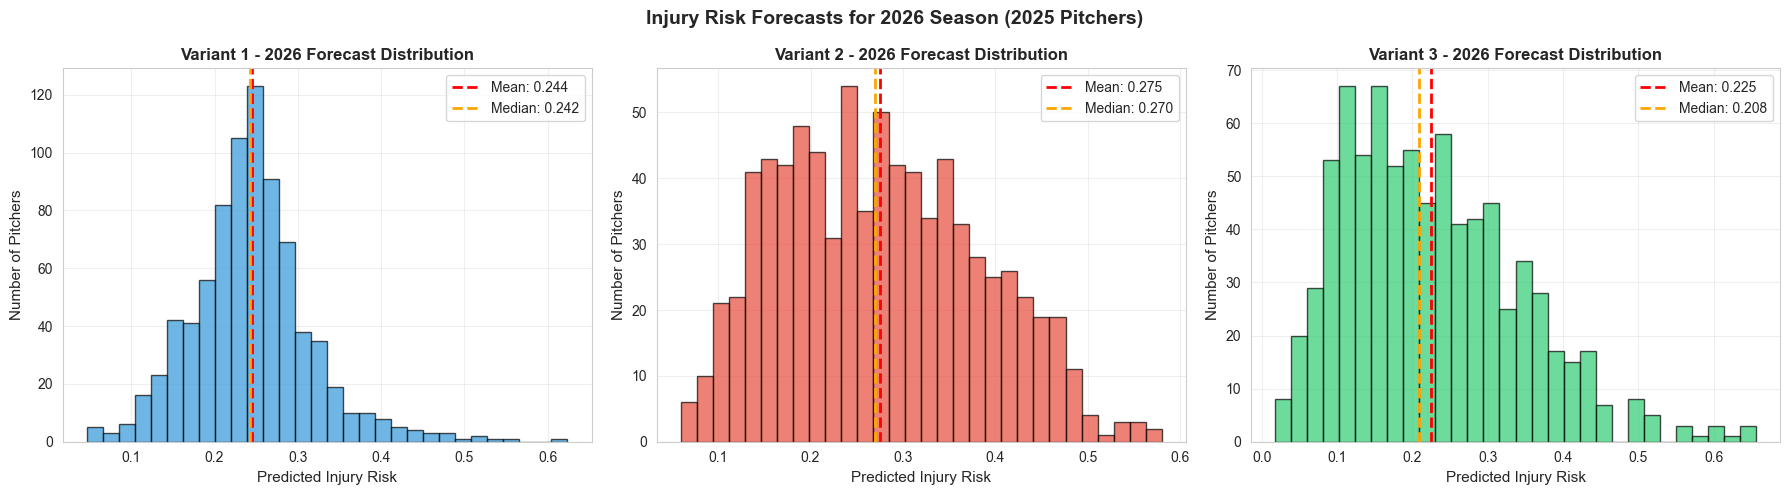

In [58]:
# Create forecast dataframe with predictions
# Check which columns are available in forecast_df
available_cols = []
for col in ['player_name', 'game_year']:
    if col in forecast_df.columns:
        available_cols.append(col)

# If forecast_df doesn't have the columns, use the original df filtered to 2025
if len(available_cols) < 2:
    # Get the columns from the original dataframe
    forecast_results = df[df['game_year'] == '2025'][['player_name', 'game_year']].copy()
else:
    forecast_results = forecast_df[available_cols].copy()

for variant in [1, 2, 3]:
    forecast_pred = globals()[f'forecast_pred_v{variant}']
    forecast_results[f'variant_{variant}_prob'] = forecast_pred

# Summary statistics
forecast_summary = []
for variant in [1, 2, 3]:
    prob_col = f'variant_{variant}_prob'
    valid_probs = forecast_results[prob_col].dropna()
    if len(valid_probs) > 0:
        forecast_summary.append({
            'Variant': variant,
            'Mean Risk': f"{valid_probs.mean():.3f}",
            'Median Risk': f"{valid_probs.median():.3f}",
            'Min Risk': f"{valid_probs.min():.3f}",
            'Max Risk': f"{valid_probs.max():.3f}",
            'Risk > 0.3': (valid_probs > 0.3).sum(),
            'Risk > 0.5': (valid_probs > 0.5).sum()
        })
print(pd.DataFrame(forecast_summary).to_string(index=False))

# Visualize forecast distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, variant in enumerate([1, 2, 3]):
    ax = axes[idx]
    prob_col = f'variant_{variant}_prob'
    valid_probs = forecast_results[prob_col].dropna()
    
    if len(valid_probs) > 0:
        ax.hist(valid_probs, bins=30, edgecolor='black', alpha=0.7, color=['#3498db', '#e74c3c', '#2ecc71'][idx])
        ax.axvline(valid_probs.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {valid_probs.mean():.3f}')
        ax.axvline(valid_probs.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {valid_probs.median():.3f}')
        ax.set_xlabel('Predicted Injury Risk', fontsize=11)
        ax.set_ylabel('Number of Pitchers', fontsize=11)
        ax.set_title(f'Variant {variant} - 2026 Forecast Distribution', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle('Injury Risk Forecasts for 2026 Season (2025 Pitchers)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Save forecasts
forecast_results.to_csv('injury_risk_forecasts_2026.csv', index=False)


## Step 6: Model Diagnostics and Summary



Variant 1 (Unmodifiable)
<__main__.build_logistic_model.<locals>.SklearnLogitWrapper.summary.<locals>.Summary object at 0x000001D1DE39C0D0>

Variant 2 (Modifiable)
                           Logit Regression Results                           
Dep. Variable:       injury_next_year   No. Observations:                 4695
Model:                          Logit   Df Residuals:                     4671
Method:                           MLE   Df Model:                           23
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:                 0.05711
Time:                        03:10:35   Log-Likelihood:                -2223.0
converged:                       True   LL-Null:                       -2357.7
Covariance Type:            nonrobust   LLR p-value:                 6.949e-44
                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

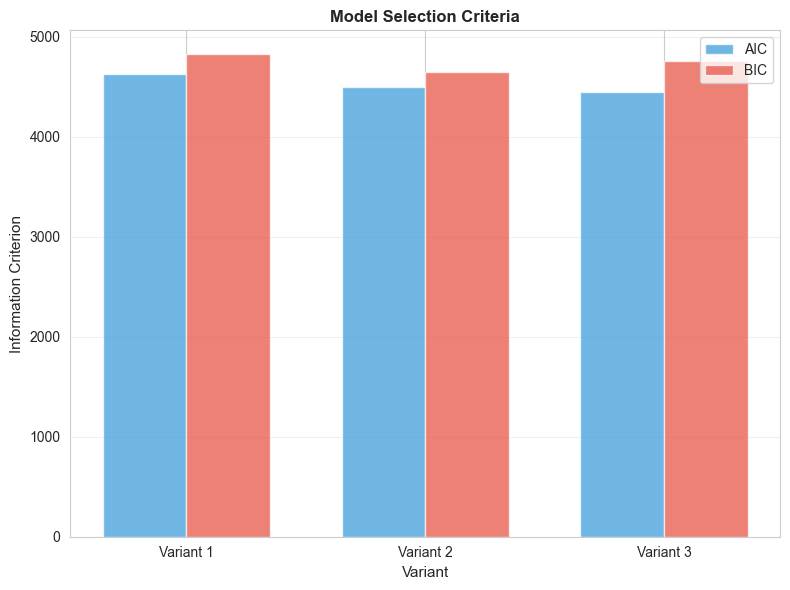

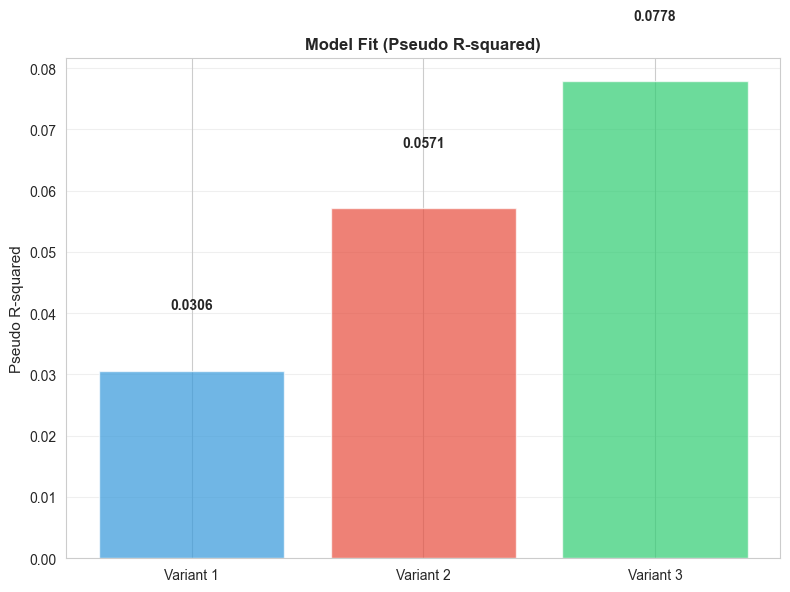

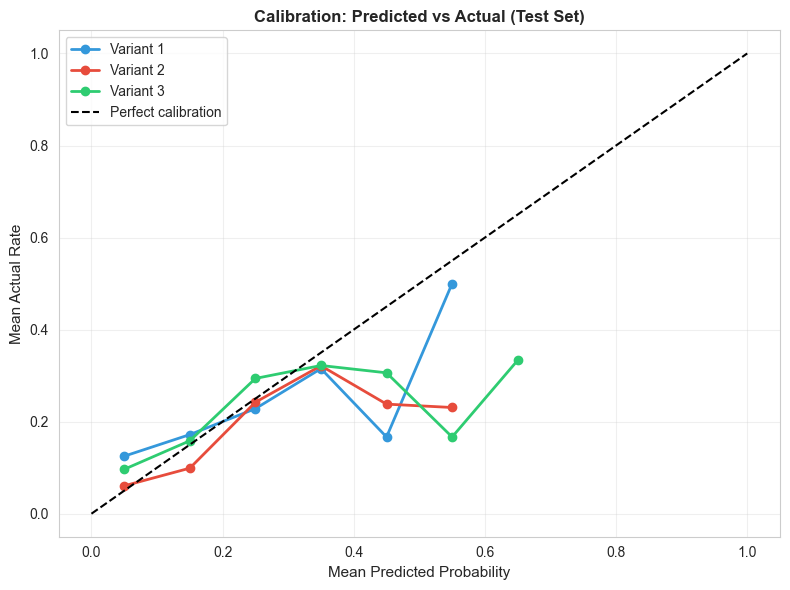

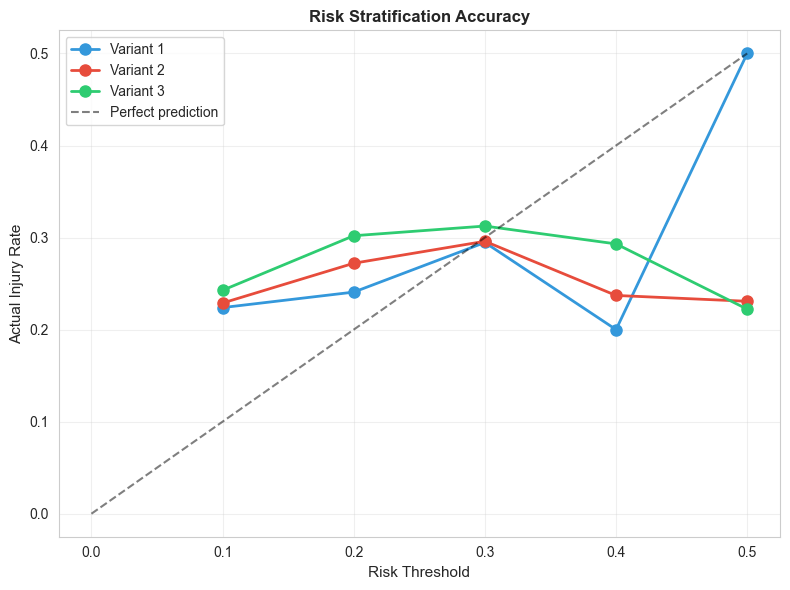

In [ ]:
# Display model summaries using statsmodels
for variant, name in [(1, 'Variant 1 (Unmodifiable)'), (2, 'Variant 2 (Modifiable)'), (3, 'Variant 3 (All)')]:
    model = globals()[f'model_v{variant}']
    print(f"\n{name}")
    print("="*80)
    if hasattr(model, 'summary'):
        summary = model.summary()
        if hasattr(summary, '__str__'):
            print(str(summary))
        else:
            print(summary)
    else:
        # Fallback for models without summary method
        print(f"AIC: {model.aic:.2f}, BIC: {model.bic:.2f}, Pseudo R²: {model.prsquared:.4f}")

# 1. AIC/BIC comparison
fig1, ax1 = plt.subplots(figsize=(8, 6))
variants = ['Variant 1', 'Variant 2', 'Variant 3']
aic_values = [model_v1.aic, model_v2.aic, model_v3.aic]
bic_values = [model_v1.bic, model_v2.bic, model_v3.bic]
x = np.arange(len(variants))
width = 0.35
ax1.bar(x - width/2, aic_values, width, label='AIC', color='#3498db', alpha=0.7)
ax1.bar(x + width/2, bic_values, width, label='BIC', color='#e74c3c', alpha=0.7)
ax1.set_xlabel('Variant', fontsize=11)
ax1.set_ylabel('Information Criterion', fontsize=11)
ax1.set_title('Model Selection Criteria', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(variants)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 2. Pseudo R-squared comparison
fig2, ax2 = plt.subplots(figsize=(8, 6))
pseudo_r2 = [model_v1.prsquared, model_v2.prsquared, model_v3.prsquared]
ax2.bar(variants, pseudo_r2, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
ax2.set_ylabel('Pseudo R-squared', fontsize=11)
ax2.set_title('Model Fit (Pseudo R-squared)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(pseudo_r2):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Prediction vs Actual (Test set)
fig3, ax3 = plt.subplots(figsize=(8, 6))
for variant, name, color in [(1, 'Variant 1', '#3498db'), (2, 'Variant 2', '#e74c3c'), (3, 'Variant 3', '#2ecc71')]:
    test_pred = globals()[f'test_pred_v{variant}']
    test_data = globals()[f'test_v{variant}']
    test_true = test_data['injury_next_year'].values
    valid_mask = ~np.isnan(test_pred)
    if valid_mask.sum() > 0:
        y_true_clean = test_true[valid_mask]
        y_pred_clean = test_pred[valid_mask]
        # Create bins and calculate mean actual vs mean predicted
        bins = np.linspace(0, 1, 11)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_indices = np.digitize(y_pred_clean, bins) - 1
        bin_indices = np.clip(bin_indices, 0, len(bin_centers) - 1)
        
        mean_actual = [y_true_clean[bin_indices == i].mean() if (bin_indices == i).sum() > 0 else np.nan 
                      for i in range(len(bin_centers))]
        mean_pred = [y_pred_clean[bin_indices == i].mean() if (bin_indices == i).sum() > 0 else np.nan 
                    for i in range(len(bin_centers))]
        
        valid_bins = ~np.isnan(mean_actual)
        if valid_bins.sum() > 0:
            ax3.plot(np.array(bin_centers)[valid_bins], np.array(mean_actual)[valid_bins], 
                    'o-', label=name, color=color, linewidth=2, markersize=6)
ax3.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=1.5)
ax3.set_xlabel('Mean Predicted Probability', fontsize=11)
ax3.set_ylabel('Mean Actual Rate', fontsize=11)
ax3.set_title('Calibration: Predicted vs Actual (Test Set)', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Risk stratification
fig4, ax4 = plt.subplots(figsize=(8, 6))
risk_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for variant, name, color in [(1, 'Variant 1', '#3498db'), (2, 'Variant 2', '#e74c3c'), (3, 'Variant 3', '#2ecc71')]:
    test_pred = globals()[f'test_pred_v{variant}']
    test_data = globals()[f'test_v{variant}']
    test_true = test_data['injury_next_year'].values
    valid_mask = ~np.isnan(test_pred)
    if valid_mask.sum() > 0:
        y_true_clean = test_true[valid_mask]
        y_pred_clean = test_pred[valid_mask]
        
        # Calculate actual injury rate for each risk category
        actual_rates = []
        for threshold in risk_thresholds:
            high_risk = y_pred_clean >= threshold
            if high_risk.sum() > 0:
                actual_rates.append(y_true_clean[high_risk].mean())
            else:
                actual_rates.append(np.nan)
        
        ax4.plot(risk_thresholds, actual_rates, 'o-', label=name, color=color, linewidth=2, markersize=8)
ax4.plot([0, 0.5], [0, 0.5], 'k--', label='Perfect prediction', linewidth=1.5, alpha=0.5)
ax4.set_xlabel('Risk Threshold', fontsize=11)
ax4.set_ylabel('Actual Injury Rate', fontsize=11)
ax4.set_title('Risk Stratification Accuracy', fontweight='bold', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [60]:
# Model fit statistics
fit_stats = []
for variant, name in [(1, 'Variant 1 (Unmodifiable)'), (2, 'Variant 2 (Modifiable)'), (3, 'Variant 3 (All)')]:
    model = globals()[f'model_v{variant}']
    fit_stats.append({
        'Model': name,
        'AIC': f"{model.aic:.2f}",
        'BIC': f"{model.bic:.2f}",
        'Log-Likelihood': f"{model.llf:.2f}",
        'Pseudo R²': f"{model.prsquared:.4f}",
        'N': model.nobs,
        'Converged': model.mle_retvals['converged'] if hasattr(model, 'mle_retvals') else 'N/A'
    })
print("Model Fit Statistics:")
print(pd.DataFrame(fit_stats).to_string(index=False))

# Test set performance metrics
perf_metrics = []
for variant, name in [(1, 'Variant 1 (Unmodifiable)'), (2, 'Variant 2 (Modifiable)'), (3, 'Variant 3 (All)')]:
    test_pred = globals()[f'test_pred_v{variant}']
    test_data = globals()[f'test_v{variant}']
    test_true = test_data['injury_next_year'].values
    valid_mask = ~np.isnan(test_pred)
    
    if valid_mask.sum() > 0:
        y_true_clean = test_true[valid_mask]
        y_pred_clean = test_pred[valid_mask]
        
        perf_metrics.append({
            'Model': name,
            'Log Loss': f"{log_loss(y_true_clean, y_pred_clean):.4f}",
            'Brier Score': f"{brier_score_loss(y_true_clean, y_pred_clean):.4f}",
            'ROC-AUC': f"{roc_auc_score(y_true_clean, y_pred_clean):.4f}" if len(np.unique(y_true_clean)) > 1 else 'N/A',
            'Mean Predicted': f"{y_pred_clean.mean():.4f}",
            'Actual Rate': f"{y_true_clean.mean():.4f}"
        })

print("\nTest Set Performance Metrics:")
print(pd.DataFrame(perf_metrics).to_string(index=False))


Model Fit Statistics:
                   Model     AIC     BIC Log-Likelihood Pseudo R²    N  Converged
Variant 1 (Unmodifiable) 4630.89 4824.52       -2285.45    0.0306 4695       True
  Variant 2 (Modifiable) 4494.08 4648.99       -2223.04    0.0571 4695       True
         Variant 3 (All) 4444.31 4754.12       -2174.16    0.0778 4695       True

Test Set Performance Metrics:
                   Model Log Loss Brier Score ROC-AUC Mean Predicted Actual Rate
Variant 1 (Unmodifiable)   0.5278      0.1724  0.5667         0.2380      0.2219
  Variant 2 (Modifiable)   0.5197      0.1715  0.6217         0.2724      0.2219
         Variant 3 (All)   0.5125      0.1685  0.6396         0.2178      0.2219
